In [1]:
# from deap import base, creator, tools, algorithms
from dedalus import public as de
from dedalus.extras.plot_tools import plot_bot_2d
from dedalus.extras import *
import numpy as np
import scipy
from scipy import integrate
import pickle
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time as timeski
import os

#Suppress most Dedalus output
de.logging_setup.rootlogger.setLevel('ERROR')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
# rcParams['font.sans-serif'] = ['Tahoma']
rcParams.update({'font.size': 16})

In [4]:
###################################################################
# Simulation Functions
###################################################################

#Scale list between 0 and 1
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

# steady state ODE
def ssODE(y,t,params):
    u,v,g,G = y
    b,gamma,n,delta,e,c,d = params
    
    du = b*v+v*gamma*u**n/(1+u**n)-delta*u-e*G*u
    dv = -du
    
    dG = c*u*g-d*G
    dg = - dG
    
    derivs = [du,dv,dg,dG]
    return derivs

#determine homogenous SS using ssODE
def homogenousSS(u,v,g,G,params):

    y0 = (u,v,g,G)
    t_sim = (0,1000)
    odeSoln = integrate.odeint(ssODE,y0,t_sim,args=(params,),mxstep=1000000) 
      
    return(odeSoln[1])

def logistic_decay(x,p_min,p_max,k,x0=1.75):  
    #positive k -> decay
    p_amp = p_max - p_min
    return p_min+p_amp/(1+np.exp(k*(x-x0)))

def WPGAP(params):
    c_p,c_m,gamma_p,gamma_m,e,d = params
    
    #fixed parameters
    b = 0.0002
    c_s = 0.1
    gamma_s = 0.0005
    delta = 0.04
    
    if c_p < c_s or gamma_p < gamma_s:
        return('Rates decreased over disk')

    #Bases:names,modes,intervals,dealiasing
    phi_basis=de.Fourier('p',64,interval=(0,2*np.pi),dealias=3/2)
    r_basis=de.Chebyshev('r',64,interval=(0,4),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([phi_basis,r_basis],float)
    phi, r = domain.grids(scales=1)

    mu_F = 1.75

    c = domain.new_field(name='c')
    gamma = domain.new_field(name='gamma')
    
    c['g'] = logistic_decay(r[0],c_s,c_p,c_m,x0=mu_F) 
    c.meta['p']['constant'] = True

    gamma['g'] = logistic_decay(r[0],gamma_s,gamma_p,gamma_m,x0=mu_F)
    gamma.meta['p']['constant'] = True

    T = 4.04
    Tg = 10

    n = 2
    K = 1
    Du = .004 
    Dv = 100*Du
    DG = 100*Du
    Dg = 100*Du
    
    params = [b,gamma_s,n,delta,e,c_s,d]
    u0,v0,g0,G0 = homogenousSS(T/2,T/2, Tg/2, Tg/2,params)

    # Specify problem
    problem = de.IVP(domain, variables=['u', 'v','ur','vr','G','g','Gr','gr'])

    problem.parameters['gamma'] = gamma
    problem.parameters['b'] = b
    problem.parameters['n'] = n
    problem.parameters['u0'] = u0
    problem.parameters['v0'] = v0
    problem.parameters['G0'] = G0
    problem.parameters['g0'] = g0
    problem.parameters['c'] = c
    problem.parameters['dd'] = d
    problem.parameters['delta'] = delta
    problem.parameters['e'] = e
    problem.parameters['Tg'] = Tg
    problem.parameters['K'] = K

    problem.parameters['Du'] = Du
    problem.parameters['Dv'] = Dv
    problem.parameters['DG'] = DG
    problem.parameters['Dg'] = Dg

    problem.substitutions['f(u,v,G)'] = 'b*v+v*gamma*u**n/(K**n+u**n)-delta*u-e*G*u'
    problem.substitutions['minf(u,v,G)'] = '-f(u,v,G)'
    problem.substitutions['fg(u,G,g)'] = 'c*u*g-dd*G'
    problem.substitutions['minfg(u,G,g)'] = '-fg(u,G,g)'

    problem.add_equation("r**2*dt(u)-r**2*Du*dr(ur)-r*Du*dr(u)-Du*dp(dp(u))=r**2*f(u,v,G)")
    problem.add_equation("r**2*dt(v)-r**2*Dv*dr(vr)-r*Dv*dr(v)-Dv*dp(dp(v))=r**2*minf(u,v,G)")
    problem.add_equation("r**2*dt(G)-r**2*DG*dr(Gr)-r*DG*dr(G)-DG*dp(dp(G))=r**2*fg(u,G,g)")
    problem.add_equation("r**2*dt(g)-r**2*Dg*dr(gr)-r*Dg*dr(g)-Dg*dp(dp(g))=r**2*minfg(u,G,g)")

    problem.add_equation("ur-dr(u)=0")
    problem.add_equation("vr-dr(v)=0")
    problem.add_equation("Gr-dr(G)=0")
    problem.add_equation("gr-dr(g)=0")

    #Reflective boundary conditions
    problem.add_bc("left (ur) = 0")
    problem.add_bc("right (ur) = 0")
    problem.add_bc("left (vr) = 0")
    problem.add_bc("right (vr) = 0")
    problem.add_bc("left (Gr) = 0")
    problem.add_bc("right (Gr) = 0")
    problem.add_bc("left (gr) = 0")
    problem.add_bc("right (gr) = 0")


    # Pick a timestepper
    ts = de.timesteppers.RK222
    # Build solver
    solver = problem.build_solver(ts)
    # Set integration limits
    solver.stop_wall_time = np.inf
    solver.stop_sim_time = np.inf
    solver.stop_iteration = np.inf
    # Set initial conditions
    u = solver.state ['u']
    v = solver.state['v']
    G = solver.state ['G']
    g = solver.state['g']
    u_seed = pickle.load( open( "PR_9Dots.pickle", "rb" ) )
    u_seed_norm = u_seed/np.max(u_seed)
    urand = 0.1*v0*np.random.rand(*u['g'].shape) + 0.1*v0*u_seed_norm

    u['g'] = u0+urand
    v['g'] = v0-urand
    G['g'] = G0*np.ones(G['g'].shape)
    g['g'] = g0*np.ones(g['g'].shape)

    phi, r = domain.grids(scales=domain.dealias)
    phi = np.vstack((phi,2*np.pi))
    phi,r = np.meshgrid(phi,r)

    solver.stop_iteration = 600

    dt = 0.25
    nonan = True
    # curr_t = 0
    # Main loop chceking stopping criteria
    while solver.ok and nonan:
        # Step forward
        solver.step(dt)

        if solver.iteration % 10 == 0:
            if np.count_nonzero(np.isnan(u['g'])) > 0 or np.min(u['g']) < 0 :
                return('Numerical Error')
                nonan = False        


                
    z = np.vstack((u['g'],u['g'][0])).T
#     fig = plt.figure() #figsize = (18,6))
    # ax = Axes3D(fig)

    plt.subplot(projection="polar")

    plt.pcolormesh(phi,r,z,shading='auto')#,vmin=0., vmax = .8)

    plt.plot(phi, r, color='k', ls='none') 
#         plt.legend(['t={}'.format(curr_t)],framealpha=0)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
#     plt.title('Index:%.i Score:%.2f'%(index,score))
#     plt.savefig('FiguresRadialPHJoint/Spontaneous_Init_Index%.i.png'%(index),bbox_inches='tight',dpi=300)

    plt.figure()
    plt.plot(np.mean(z,axis=0))
    plt.plot(np.mean(z,axis=1))
    
    return u['g'].T

#Score function to score each parameter set
def ScoreFxn(learned_params, index, score):
    
    usim = WPGAP(learned_params, index,score)
    if type(usim) == str:
        return 10e15, []

    avg_curr = []
    q1_std, q2_std , q3_std , q4_std = [],[],[],[]
    inc = len(usim[0])//4
    for i in range(len(usim)):
        avg_curr.append(np.mean(usim[i]))
        q1_std.append(np.std(usim[i][0:inc]))
        q2_std.append(np.std(usim[i][inc:2*inc]))
        q3_std.append(np.std(usim[i][2*inc:3*inc]))
        q4_std.append(np.std(usim[i][3*inc:4*inc]))
    q1_std = np.array(q1_std)
    q2_std = np.array(q2_std)
    q3_std = np.array(q3_std)
    q4_std = np.array(q4_std)
    # Training Data
    AVG_SF = pickle.load(open("Avg_R2_noscale.pickle", "rb"))
    STD_SF = pickle.load(open("STDev_R2_noscale.pickle", "rb"))

    #error = np.mean(np.mean(np.abs(avg_curr-AVG_SF)) + np.mean(np.abs(std_curr-STD_SF)))
    error = np.mean(np.mean(np.abs(avg_curr-AVG_SF[1]))+np.mean(np.abs(q1_std-STD_SF[1]))+np.mean(np.abs(q3_std-STD_SF[1]))+np.mean(np.abs(q3_std-STD_SF[1]))+np.mean(np.abs(q4_std-STD_SF[1])))
    print(error)
    return error,usim

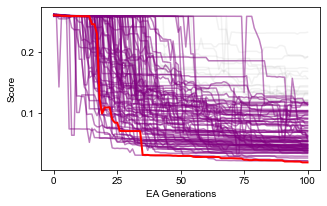

In [2]:
#Read in evolutionary algorithm runs
file_name = '012522_LogisticDecay_Act_Seeded_DG100'

folder = '../PhagoSignaling04.2021/'
file_loc = folder + file_name


path, dirs, files = os.walk(file_loc).__next__()
len_files = len(files)-1

runs_df = pd.DataFrame(index = range(len_files), columns=['Score','c_p','c_m','gamma_p','gamma_m','e','d'])

minim = 1
minim_i = 0

best_scores = []
best_inds = []
plt.figure(figsize=(5,3))
# plt.figure(figsize=(3,2))
# plt.rcParams.update({'font.size': 12})
for i in range(len_files):
    if i <10:
        logbook1 = pickle.load( open( "{}/{}_000{}.pickled".format(file_loc,file_name,i), "rb" ) )
    elif i <100:
        logbook1 = pickle.load( open( "{}/{}_00{}.pickled".format(file_loc,file_name,i), "rb" ) )
    else:
        logbook1 = pickle.load( open( "{}/{}_0{}.pickled".format(file_loc,file_name,i), "rb" ) )

    runs_df.iloc[i] = np.insert(logbook1[1][-1],0,logbook1[0][-1])
    
    if logbook1[0][-1] < minim:
        minim = logbook1[0][-1]
        minim_i = i
        
    best_scores.append(logbook1[0][-1])
    best_inds.append(logbook1[1][-1])
  
    run = np.array(logbook1[0])
    score = logbook1[0][-1]
    if score == 0.01925945932722266:
         plt.plot(run,color='red',alpha=1,lw=2,zorder=10)
    elif score <0.12: # Mean+STD
        plt.plot(run,color='purple',alpha=.5)
        
    else:
        plt.plot(run,color='gray',alpha=0.1)

plt.xlabel('EA Generations')
plt.ylabel('Score')
plt.rcParams.update({'font.size': 16})

best_scores = np.array(best_scores)

# plt.savefig('EAFigures/EAResults.png',bbox_inches='tight',dpi=300)
# plt.savefig('EAFigures/EAResults.pdf',bbox_inches='tight',dpi=300)



In [3]:
good_df = runs_df[runs_df['Score'] < 0.12].sort_values('Score')

In [5]:
good_df

,Score,c_p,c_m,gamma_p,gamma_m,e,d
73,0.019259,1.086687,24.659685,0.753797,1.464916,3.757525,4.269887
65,0.021608,1.588688,13.041296,0.796513,1.962784,2.115823,3.352316
60,0.021697,2.607906,15.179380,0.913797,2.516954,1.957533,4.012132
49,0.026531,2.259628,20.143699,0.787302,2.179599,1.751175,3.194962
81,0.029411,1.440483,31.453817,0.643876,1.566927,2.544533,3.962369
...,...,...,...,...,...,...,...
23,0.114229,8.261021,31.495437,0.599948,2.058700,0.133850,0.848670
38,0.114748,5.293123,25.560307,0.883127,1.407402,2.085298,2.372943
16,0.115603,3.599343,26.169449,0.340136,1.944874,0.277419,2.802685
67,0.116967,0.353954,31.607311,0.347479,1.018431,1.630895,4.572488


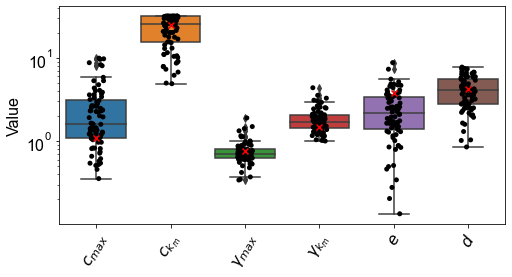

In [8]:
best = good_df.iloc[0][1:]

plt.figure(figsize = (8,4))
curr_df = good_df.drop(columns=['Score'])
sns.boxplot(data=curr_df)
sns.stripplot(data=curr_df,color='k')

plt.xticks(rotation=60)
plt.ylabel('Value')
plt.xlabel('')
plt.yscale('log')

plt.scatter(np.arange(0,6),best,c='r',marker='x',zorder=10)

plt.xticks(np.arange(0,6),[r'$c_{max}$',r'$c_{k_m}$',r'$\gamma_{max}$',r'$\gamma_{k_m}$',r'$e$',r'$d$'])

# plt.savefig('EAFigures/EAParams.png',bbox_inches='tight',dpi=300)
# plt.savefig('EAFigures/EAParams.pdf',bbox_inches='tight',dpi=300)

plt.show()